In [135]:
import requests
import pandas as pd
import json
import psycopg2
from sqlalchemy import create_engine 
from dask.diagnostics import ProgressBar
import dask.dataframe as dd
import dask.array as da
import seaborn as sns
import matplotlib.pyplot as plt

# Extracting Data

In [136]:
%time df = dd.read_csv("C:\\EZOIC_ASSESSMENT\\311_Service_Requests_from_2010_to_Present.csv")

Wall time: 380 ms


In [137]:
pd.set_option('display.max_rows',100)
print(df.dtypes)

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                        int64
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Intersection Street 1              object
Intersection Street 2              object
Address Type                       object
City                               object
Landmark                          float64
Facility Type                      object
Status                             object
Due Date                           object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                   

In [138]:
#print(df.head())

#### Some of the datatypes are wrong 

### The data types were initialized incorrectly for some of the columns

String columns should be intialized as 'Object' instead of 'float' we need to convert it in dataframe as below and deal with null values too

In [139]:
%time df1 = dd.read_csv("C:\\EZOIC_ASSESSMENT\\311_Service_Requests_from_2010_to_Present.csv",dtype={'Incident Zip':'object','Vehicle Type': 'object','Bridge Highway Direction': 'object','Bridge Highway Name': 'object','Bridge Highway Segment': 'object','Landmark': 'object','Road Ramp': 'object','Taxi Company Borough': 'object','X Coordinate (State Plane)':'float64','Y Coordinate (State Plane)':'float64'})

Wall time: 348 ms


In [140]:
df1.dtypes

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                       object
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Intersection Street 1              object
Intersection Street 2              object
Address Type                       object
City                               object
Landmark                           object
Facility Type                      object
Status                             object
Due Date                           object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                   

Checking Missing Values on new dataframe

#### MISSING VALUES

In [141]:
missing_values = df1.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Address Type                  int64
Y Coordinate (State Plane)      ...
dtype: int64
Dask Name: dataframe-sum-agg, 996 tasks

#### MISSING VALUES PERCENTAGE

In [142]:
missing_count = ((missing_values / df1.index.size) * 100)
missing_count

Dask Series Structure:
npartitions=1
Address Type                  float64
Y Coordinate (State Plane)        ...
dtype: float64
Dask Name: mul, 1397 tasks

In [143]:
with ProgressBar():
    missing_count_pct = missing_count.compute()
missing_count_pct

[###########                             ] | 28% Completed |  1min 25.3s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##############                          ] | 35% Completed |  1min 47.3s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############                         ] | 38% Completed |  1min 57.6s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############################         ] | 79% Completed |  4min  3.2s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[################################        ] | 80% Completed |  4min  6.0s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (18,20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed |  4min 54.8s


Unique Key                         0.000000
Created Date                       0.000000
Closed Date                        2.690807
Agency                             0.000000
Agency Name                        0.000000
Complaint Type                     0.000000
Descriptor                         1.131278
Location Type                     24.963603
Incident Zip                       5.830547
Incident Address                  18.792759
Street Name                       18.798970
Cross Street 1                    33.027832
Cross Street 2                    33.381905
Intersection Street 1             81.865365
Intersection Street 2             81.898895
Address Type                       6.930854
City                               6.117111
Landmark                          96.974592
Facility Type                     75.266947
Status                             0.000000
Due Date                          61.175572
Resolution Description             2.227937
Resolution Action Updated Date  

1. Now here It is impotrant to remove those columns whose missing value percentage is >60.
2. We cant do operations/trainel model to predict a column whose 60 % of values are missing
3. Borough has 0% values missing 2nd question can be answered but before that check for innacurate characters (Incident Zip)

In [144]:
columns_to_drop = missing_count_pct[missing_count_pct > 60].index
with ProgressBar():
    df_dropped = df1.drop(columns_to_drop, axis=1).persist()

[###########                             ] | 28% Completed |  1min 15.7s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##############                          ] | 35% Completed |  1min 35.4s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############                         ] | 38% Completed |  1min 44.9s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############################         ] | 79% Completed |  4min 12.0s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[################################        ] | 80% Completed |  4min 12.7s

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\core.py:118: DtypeWarning: Columns (18,20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed |  5min 12.2s


In [145]:
df_dropped.dtypes

Unique Key                          int64
Created Date                       object
Closed Date                        object
Agency                             object
Agency Name                        object
Complaint Type                     object
Descriptor                         object
Location Type                      object
Incident Zip                       object
Incident Address                   object
Street Name                        object
Cross Street 1                     object
Cross Street 2                     object
Address Type                       object
City                               object
Status                             object
Resolution Description             object
Resolution Action Updated Date     object
Community Board                    object
BBL                               float64
Borough                            object
X Coordinate (State Plane)        float64
Y Coordinate (State Plane)        float64
Open Data Channel Type            

In [146]:
df_dropped.tail()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Latitude,Longitude,Location
83771,27842649,04/14/2014 08:48:00 AM,04/21/2014 04:45:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Construction Equipment (NC1),NaN,10006,34 WEST STREET,...,1.000168e+09,MANHATTAN,979814.0,196782.0,ONLINE,Unspecified,MANHATTAN,40.706797,-74.016000,"(40.70679678045445, -74.01599985239896)"
83772,27842650,04/14/2014 11:02:00 PM,04/15/2014 08:00:00 PM,DEP,Department of Environmental Protection,Noise,Noise: Jack Hammering (NC2),NaN,10036,NaN,...,NaN,MANHATTAN,988913.0,214759.0,PHONE,Unspecified,MANHATTAN,40.756139,-73.983169,"(40.75613911897527, -73.98316894112523)"
83773,27842652,04/14/2014 12:21:00 PM,04/20/2014 06:30:00 PM,DEP,Department of Environmental Protection,Sewer,Defective/Missing Curb Piece (SC4),NaN,11228,NaN,...,NaN,BROOKLYN,984518.0,164775.0,PHONE,Unspecified,BROOKLYN,40.618946,-73.999035,"(40.61894576099455, -73.99903464452899)"
83774,27842653,04/14/2014 01:26:00 PM,04/18/2014 10:45:00 AM,DEP,Department of Environmental Protection,Sewer,Catch Basin Clogged/Flooding (Use Comments) (SC),NaN,10469,2305 ELY AVENUE,...,2.044220e+09,BRONX,1031185.0,252600.0,PHONE,Unspecified,BRONX,40.859879,-73.830324,"(40.859878648052884, -73.83032415755054)"
83775,27842654,04/14/2014 09:06:00 AM,04/14/2014 09:34:00 AM,DEP,Department of Environmental Protection,Sewer,Sewer Backup (Use Comments) (SA),NaN,10472,1691 EAST 174 STREET,...,2.038920e+09,BRONX,1019600.0,243325.0,ONLINE,Unspecified,BRONX,40.834476,-73.872254,"(40.83447552234542, -73.87225419756115)"


In [147]:
a = df1.shape
print("Before dropped Columns",a[0].compute(),a[1])
a = df_dropped.shape
print("After dropped Columns",a[0].compute(),a[1])

C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:222: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)
C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:222: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)
C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:222: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)
C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\local.py:222: DtypeWarning: Columns (20,33) have mixed types. Specify dtype option on import or set low_memory=False.
  result = _execute_task(task, data)
C:\Users\pavani.nrusimhdevara\AppData\

Before dropped Columns 22314047 41
After dropped Columns 22314047 29


#### 1. How many incidents were opened in each year (beginning with 2010)?
#### 2. Which borough has the most incidents?

To Answer 1 and 2 and Questions
1. Check Unique Key is not repeating (As Each Unique Key represents a service request)
2. Convert Craeted Date (Incident is craeted on thsi date) look for year variable and count UniqueKeys

In [148]:
df_incidents = pd.read_csv(
    "C:\\EZOIC_ASSESSMENT\\311_Service_Requests_from_2010_to_Present.csv",
    usecols = [
        'Unique Key',
        'Created Date',
        'Closed Date',
        'Borough',
        'City'
    ]
)

In [149]:
df_incidents["Created Date"] = pd.to_datetime(
    df_incidents["Created Date"],
    format = "%m/%d/%Y %H:%M:%S %p"   
)

In [150]:
df_incidents_year = df_incidents[df_incidents['Created Date'].dt.year>2009]
df_incidents_year['Year'] = df_incidents['Created Date'].dt.year
df_incidents_year

,Unique Key,Created Date,Closed Date,City,Borough,Year
0,27842655,2014-04-14 02:42:00,08/20/2014 10:55:00 AM,STATEN ISLAND,STATEN ISLAND,2014
1,27842656,2014-04-14 11:04:00,05/01/2015 02:00:00 PM,BRONX,BRONX,2014
2,27842659,2014-04-14 01:27:00,04/14/2014 03:03:00 PM,Queens Village,QUEENS,2014
3,27842660,2014-04-14 12:51:00,04/14/2014 02:15:00 PM,STATEN ISLAND,STATEN ISLAND,2014
4,27842663,2014-04-14 12:35:00,04/14/2014 02:28:00 PM,Jamaica,QUEENS,2014
5,27842665,2014-04-14 09:11:00,04/17/2014 01:00:00 PM,STATEN ISLAND,STATEN ISLAND,2014
6,27842668,2014-04-14 12:35:00,04/15/2014 09:35:00 AM,BROOKLYN,BROOKLYN,2014
7,27842670,2014-04-14 08:16:00,04/24/2014 11:15:00 AM,NEW YORK,MANHATTAN,2014
8,27842671,2014-04-14 12:29:00,04/14/2014 07:10:00 PM,STATEN ISLAND,STATEN ISLAND,2014
9,27842672,2014-04-14 01:11:00,04/14/2014 07:00:00 AM,East Elmhurst,QUEENS,2014


In [151]:
k = pd.DataFrame(df_incidents_year[['Unique Key']].groupby(df_incidents_year['Year']).agg(['count'])).reset_index()
k
#k.info()

,Year,Unique Key
,,count
0,2010,2031813
1,2011,1961598
2,2012,1796172
3,2013,1839974
4,2014,2114000
5,2015,2300760
6,2016,2391426
7,2017,2491969
8,2018,2747950


In [152]:
l = pd.DataFrame(df_incidents_year[['Unique Key']].groupby(df_incidents_year['Borough']).agg(['count'])).reset_index()
l

,Borough,Unique Key
,,count
0,BRONX,3891635
1,BROOKLYN,6642260
2,MANHATTAN,4345863
3,QUEENS,5103254
4,STATEN ISLAND,1119291
5,Unspecified,1211744


### Brooklyn has more Incidents

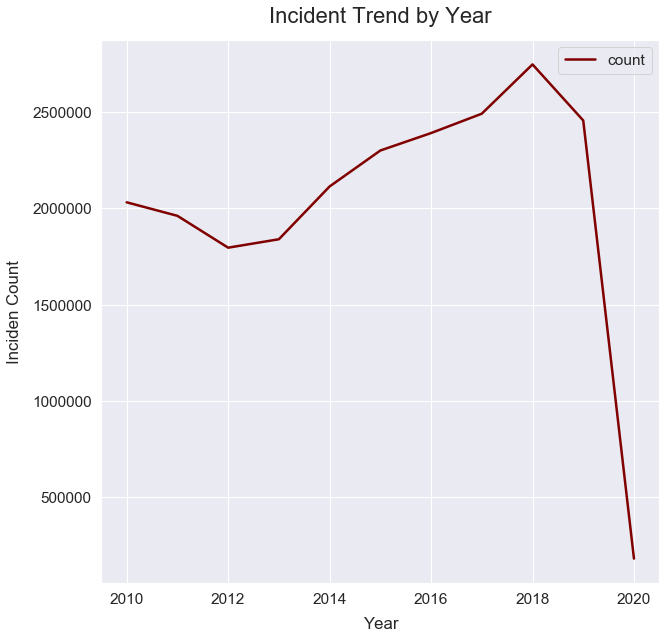

In [153]:
sns.set(font_scale=1.4)
k.set_index('Year')['Unique Key'].plot(figsize=(10, 10), linewidth=2.5, color='maroon')
plt.xlabel("Year", labelpad=10)
plt.ylabel("Inciden Count", labelpad=10)
plt.title("Incident Trend by Year", y=1.02, fontsize=22);

In [154]:
#df_incidents_year.groupby('Year')['Unique Key'].agg(['sum','count'])['count']

1. Know your Variables
2. Need to fill in missing Values 
3. Rename Cols if needed
4. Check for Unnecessary Characters and replace them
5. Change the Data Types



#### Complaints can be of Various Types 

Ex:We cannot say a Vehicle Type for a complaint replated to home

In [155]:
with ProgressBar():
    print(df_dropped['Agency'].unique().head(1000))

[########################################] | 100% Completed |  5.6s
0       DEP
1     DOHMH
2       DOT
3      DSNY
4       HPD
5      NYPD
6       DOB
7       DPR
8      DFTA
9       TLC
10      DHS
11    3-1-1
12      DCA
13      DOE
14      EDC
15    DOITT
16    NYCEM
17      DOF
18     FDNY
19      DVS
20    DORIS
21      HRA
22      ACS
23     DCAS
24      TAX
25      DCP
26     COIB
27      MOC
28      CEO
29      TAT
30      OMB
Name: Agency, dtype: object


C:\Users\pavani.nrusimhdevara\AppData\Local\Continuum\anaconda3\lib\site-packages\dask\dataframe\core.py:5916: UserWarning: Insufficient elements for `head`. 1000 elements requested, only 31 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


In [156]:
with ProgressBar():
    print(df_dropped['Agency Name'].unique().head(1000))

[########################################] | 100% Completed |  6.7s
0                 Department of Environmental Protection
1                Department of Health and Mental Hygiene
2                           Department of Transportation
3                                      BCC - Queens East
4                                           Manhattan 01
5                                           Manhattan 02
6                                   BCC - Brooklyn North
7                                   BCC - Brooklyn South
8                                      BCC - Queens West
9                                            BCC - Bronx
10     Department of Housing Preservation and Develop...
11                       New York City Police Department
12                                          A - Brooklyn
13                               Department of Buildings
14     A - Illegal Posting Staten Island, Queens and ...
15                                         A - Manhattan
16               A -

1. Comaplaints fall under on the above 31 agencies so the type of compalint can be categorized according to agency types
2. Each may consists of different departments and Each City has different Agencies

This to look into ...

1. My Complaint Type Can be various types

2. Depending on the The type of compalint we need to evealue variables

3. Need to check if deleted columns are necessary (as they might be minor)


In [157]:
%store

Stored variables and their in-db values:
df1             -> '<unavailable>'
